-----------------------------------------
# Data visualization

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [3]:
import numpy as np
import pandas as pd
# import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook


In [18]:

# Define paths to your folders
normal_path = r'dataset\Normal'
tumor_path = r'dataset\Tumor'

# Create a list to store file paths and corresponding labels
file_paths = []
labels = []

# Loop through the 'Normal' folder and assign label 0
for file_name in os.listdir(normal_path):
    file_paths.append(os.path.join(normal_path, file_name))
    labels.append(0)  # 0 for Normal

# Loop through the 'Tumor' folder and assign label 1
for file_name in os.listdir(tumor_path):
    file_paths.append(os.path.join(tumor_path, file_name))
    labels.append(1)  # 1 for Tumor

# Create a DataFrame
data = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Split the data into train and test sets (e.g., 80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Optionally, save the train and test data to CSVs
# train_data.to_csv('train_labels.csv', index=False)
# test_data.to_csv('test_labels.csv', index=False)

# Now you can proceed with the rest of your code
# Replace 'data' with 'train_data' and 'test_data' where applicable

# For example:
print(train_data['label'].value_counts())


1    4000
0    4000
Name: label, dtype: int64




### Plot some images with and without cancer tissue for comparison

In [6]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

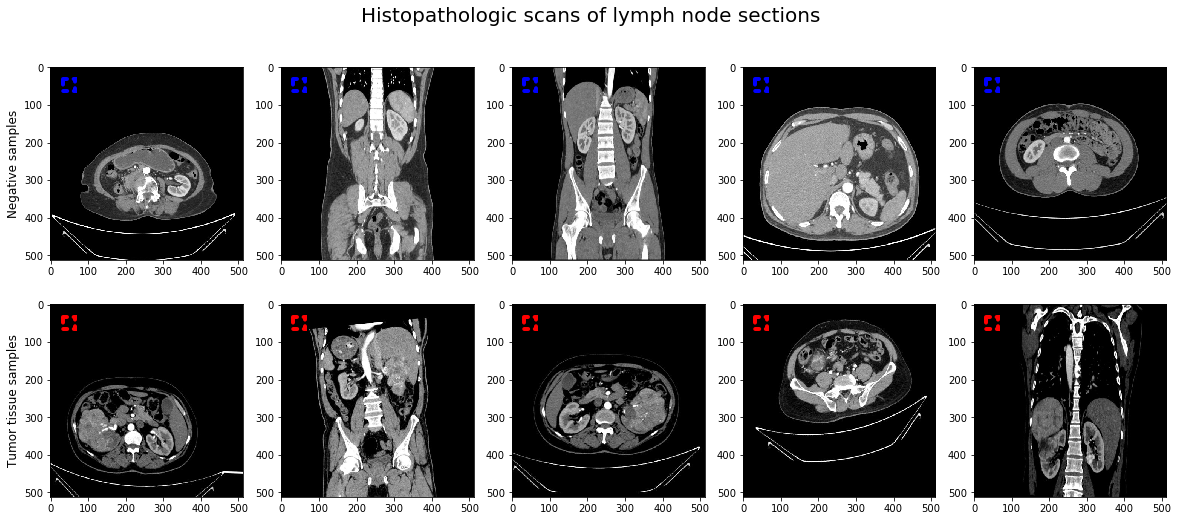

In [9]:
# Shuffle the data
shuffled_data = shuffle(train_data)


fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Histopathologic scans of lymph node sections', fontsize=20)

# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['file_path'][:5]):
    ax[0, i].imshow(readImage(idx))  # idx already contains the full path to the image
    # Create a Rectangle patch
    box = patches.Rectangle((32, 32), 32, 32, linewidth=4, edgecolor='b', facecolor='none', linestyle=':', capstyle='round')
    ax[0, i].add_patch(box)
ax[0, 0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['file_path'][:5]):
    ax[1, i].imshow(readImage(idx))  # idx already contains the full path to the image
    # Create a Rectangle patch
    box = patches.Rectangle((32, 32), 32, 32, linewidth=4, edgecolor='r', facecolor='none', linestyle=':', capstyle='round')
    ax[1, i].add_patch(box)
ax[1, 0].set_ylabel('Tumor tissue samples', size='large')

plt.show()

In [10]:
ORIGINAL_SIZE = 512  # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 450  # final size after crop
RANDOM_ROTATION = 3  # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2  # center crop shift in x and y axes, 0=no change
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5  # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations=True):
    # OpenCV reads the image in BGR format by default
    bgr_img = cv2.imread(path)
    if bgr_img is None:
        raise ValueError(f"Image at path {path} could not be read.")
        
    # We flip it to RGB for visualization purposes
    b, g, r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r, g, b])
    
    if not augmentations:
        return rgb_img / 255
    
    # Apply augmentations as before
    rotation = random.randint(-RANDOM_ROTATION, RANDOM_ROTATION)
    if RANDOM_90_DEG_TURN == 1:
        rotation += random.randint(-1, 1) * 90
    M = cv2.getRotationMatrix2D((rgb_img.shape[1] // 2, rgb_img.shape[0] // 2), rotation, 1)
    rgb_img = cv2.warpAffine(rgb_img, M, (rgb_img.shape[1], rgb_img.shape[0]))
    
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if flip_hor:
        rgb_img = rgb_img[:, ::-1]
    if flip_ver:
        rgb_img = rgb_img[::-1, :]
    
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    rgb_img = np.clip(rgb_img, 0, 1.0)

    return rgb_img

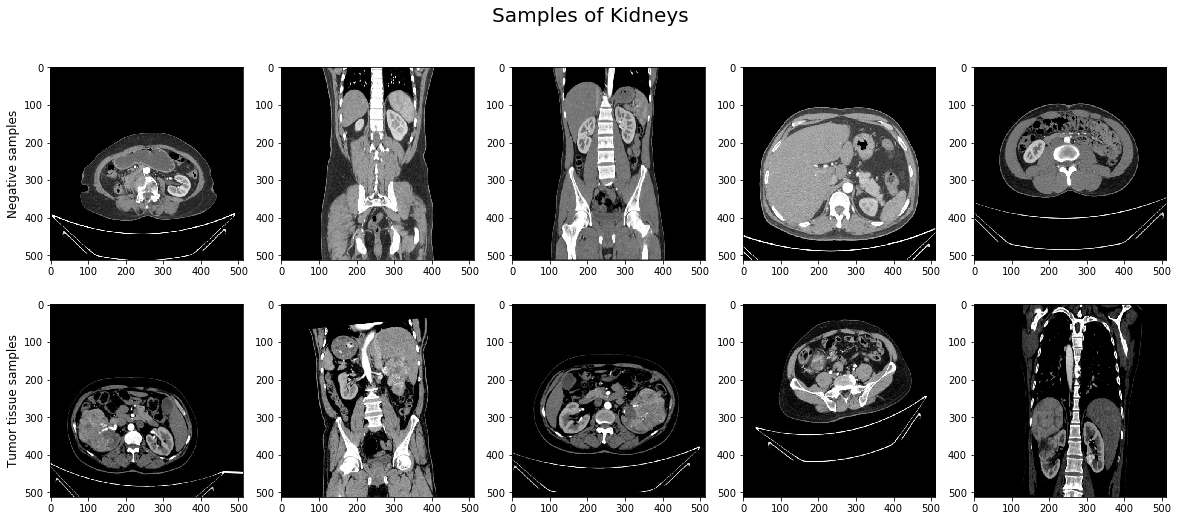

In [17]:
# Create a list to hold the data
data = []

# Plotting the images as before
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Samples of Kidneys', fontsize=20)

# Negatives (label 0)
for i, file_path in enumerate(shuffled_data[shuffled_data['label'] == 0]['file_path'][:5]):
    ax[0, i].imshow(readCroppedImage(file_path, augmentations = False))  # file_path already contains the full path to the image
ax[0, 0].set_ylabel('Negative samples', size='large')

# Positives (label 1)
for i, file_path in enumerate(shuffled_data[shuffled_data['label'] == 1]['file_path'][:5]):
    ax[1, i].imshow(readCroppedImage(file_path, augmentations = False))  # file_path already contains the full path to the image
ax[1, 0].set_ylabel('Tumor tissue samples', size='large')

plt.show()


**To see the effects of our augmentation, we can plot one image multiple times.**

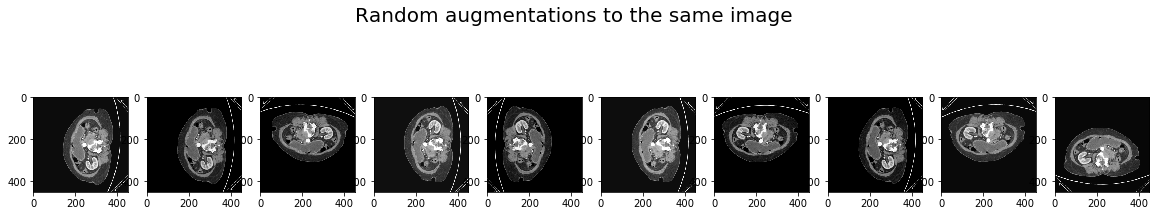

In [12]:
# fig, ax = plt.subplots(1,5, figsize=(20,4))
# fig.suptitle('Random augmentations to the same image',fontsize=20)
# # Negatives
# for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
#     for j in range(5):
#         path = os.path.join(train_path, idx)
#         ax[j].imshow(readCroppedImage(path + '.tif'))


fig, ax = plt.subplots(1, 10, figsize=(20, 4))
fig.suptitle('Random augmentations to the same image', fontsize=20)

# Select one negative sample
negative_sample = shuffled_data[shuffled_data['label'] == 0].iloc[0]['file_path']

# Display the same image with different augmentations
for j in range(10):
    ax[j].imshow(readCroppedImage(negative_sample))
    ax[j].axis('on')  # Hide the axes for clarity

plt.show()

# Baseline model

### Prepare the data and split train

In [13]:
train_df = train_data.set_index('file_path')

# Extract file paths and labels
train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

# Split into training and validation sets
tr_n, val_n, tr_idx, val_idx = train_test_split(
    train_names, 
    range(len(train_names)), 
    test_size=0.1, 
    stratify=train_labels, 
    random_state=123
)

# Convert indices back to list if needed
tr_idx = list(tr_idx)
val_idx = list(val_idx)

print(f'Training set size: {len(tr_n)}')
print(f'Validation set size: {len(val_n)}')

Training set size: 7200
Validation set size: 800
